In [1]:
!nvidia-smi

Sun Apr  7 15:00:10 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.04   Driver Version: 525.116.04   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A4000    Off  | 00000000:00:05.0 Off |                  Off |
| 41%   34C    P8    13W / 140W |      1MiB / 16376MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model

2024-04-13 17:22:45.316356: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def resnet_block(input_layer, filters, kernel_size, strides=(1, 1), activation='relu'):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    if activation:
        x = layers.Activation(activation)(x)
    return x

def build_resnet(input_shape, num_classes, type='resnet18'):
    inputs = tf.keras.Input(shape=input_shape)

    x = layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    if type == 'resnet18':
        num_blocks_list = [2, 2, 2, 2]
        filters_list = [64, 128, 256, 512]
    elif type == 'resnet34':
        num_blocks_list = [3, 4, 6, 3]
        filters_list = [64, 128, 256, 512]
    else:
        raise ValueError('ResNet type not supported')

    for i, num_blocks in enumerate(num_blocks_list):
        for j in range(num_blocks):
            strides = (1, 1)
            if i > 0 and j == 0:
                strides = (2, 2)
            if j == 0:
                shortcut = layers.Conv2D(filters_list[i], 1, strides=strides, padding='same')(x)
                shortcut = layers.BatchNormalization()(shortcut)
                x = resnet_block(x, filters_list[i], 3, strides=strides)
                x = layers.add([x, shortcut])
            else:
                x = resnet_block(x, filters_list[i], 3)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

In [6]:
# Load CIFAR-10 data
cifar10 = tf.keras.datasets.cifar10.load_data()
(x_train, y_train), (x_test, y_test) = cifar10
input_shape = x_train.shape[1:]
num_classes = 10
# Preprocess data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [14]:
# Build and compile the model
model = build_resnet(input_shape, num_classes, type='resnet34')
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_21 (Conv2D)             (None, 16, 16, 64)   9472        ['input_2[0][0]']                
                                                                                                  
 batch_normalization_21 (BatchN  (None, 16, 16, 64)  256         ['conv2d_21[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_17 (Activation)     (None, 16, 16, 64)   0           ['batch_normalization_21[0]

In [10]:
# Train the model
model.fit(x_train, y_train, batch_size=64, epochs=25, validation_data=(x_test, y_test))

Epoch 1/25
782/782 [==============================] - 10s 13ms/step - loss: 0.3306 - accuracy: 0.8875 - val_loss: 1.2310 - val_accuracy: 0.6807
Epoch 2/25
782/782 [==============================] - 9s 12ms/step - loss: 0.2819 - accuracy: 0.9052 - val_loss: 0.9954 - val_accuracy: 0.7308
Epoch 3/25
782/782 [==============================] - 10s 13ms/step - loss: 0.2492 - accuracy: 0.9170 - val_loss: 1.2275 - val_accuracy: 0.7025
Epoch 4/25
782/782 [==============================] - 10s 13ms/step - loss: 0.2123 - accuracy: 0.9282 - val_loss: 1.1840 - val_accuracy: 0.7111
Epoch 5/25
782/782 [==============================] - 10s 12ms/step - loss: 0.1834 - accuracy: 0.9379 - val_loss: 1.0506 - val_accuracy: 0.7409
Epoch 6/25
782/782 [==============================] - 10s 12ms/step - loss: 0.1620 - accuracy: 0.9459 - val_loss: 1.0827 - val_accuracy: 0.7490
Epoch 7/25
782/782 [==============================] - 9s 12ms/step - loss: 0.1477 - accuracy: 0.9502 - val_loss: 1.1693 - val_accuracy: 0

313/313 [==============================] - 2s 5ms/step - loss: 1.3180 - accuracy: 0.7475
Test Loss: 1.3180073499679565
Test Accuracy: 0.7475000023841858
313/313 [==============================] - 1s 3ms/step


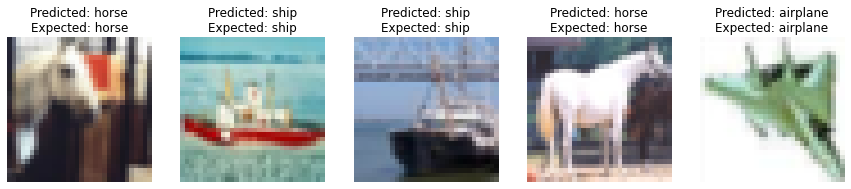

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Predict on test data
predictions = model.predict(x_test)
# Show some random predictions
num_samples_to_show = 5
random_indices = np.random.choice(range(len(x_test)), num_samples_to_show, replace=False)

plt.figure(figsize=(15, 3))

for i, idx in enumerate(random_indices):
    predicted_class_idx = np.argmax(predictions[idx])
    expected_class_idx = y_test[idx][0]
    
    predicted_class_name = class_names[predicted_class_idx]
    expected_class_name = class_names[expected_class_idx]
    
    plt.subplot(1, num_samples_to_show, i+1)
    plt.imshow(x_test[idx])
    plt.title(f"Predicted: {predicted_class_name}\nExpected: {expected_class_name}")
    plt.axis('off')

plt.show()
